# 範例 : (Kaggle)房價預測

# [教學目標]
- 以下用房價預測資料, 練習特徵重要性的寫作與觀察
- 由於只有樹狀模型有特徵重要性, 故以梯度提升樹為模型作為範例

# [範例重點]
- 使用擬合過的模型, 計算特徵重要性 (In[3], Out[3]) 
- 對照原始特徵, 觀察特徵重要性較高的一半特徵, 搭配梯度提升樹對於測結果的影響 (In[4], Out[4], In[5], Out[5])
- 重組重要性最高的特徵作為新特徵, 觀察效果如何 (In[8], Out[8]) 

In [1]:
# 做完特徵工程前的所有準備
import pandas as pd
import numpy as np
import copy
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor

data_path = 'data/'
df = pd.read_csv(data_path + 'house_train.csv.gz')

train_Y = np.log1p(df['SalePrice'])
df = df.drop(['Id', 'SalePrice'] , axis=1)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [2]:
# 因為需要把類別型與數值型特徵都加入, 故使用最簡版的特徵工程
LEncoder = LabelEncoder()
MMEncoder = MinMaxScaler()
for c in df.columns:
    df[c] = df[c].fillna(-1)
    if df[c].dtype == 'object':
        df[c] = LEncoder.fit_transform(list(df[c].values))
    df[c] = MMEncoder.fit_transform(df[c].values.reshape(-1, 1))
df.head()

D:\software\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,0.235294,0.75,0.210191,0.033420,1.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.090909,0.50,1.0,0.8
1,0.000000,0.75,0.257962,0.038795,1.0,0.0,1.0,1.0,0.0,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.363636,0.25,1.0,0.8
2,0.235294,0.75,0.219745,0.046507,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.727273,0.50,1.0,0.8
3,0.294118,0.75,0.194268,0.038561,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.090909,0.00,1.0,0.0
4,0.235294,0.75,0.270701,0.060576,1.0,0.0,0.0,1.0,0.0,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.50,1.0,0.8


In [3]:
# 梯度提升樹擬合後, 將結果依照重要性由高到低排序
estimator = GradientBoostingRegressor()
estimator.fit(df.values, train_Y)
# estimator.feature_importances_ 就是模型的特徵重要性, 這邊先與欄位名稱結合起來, 才能看到重要性與欄位名稱的對照表
feats = pd.Series(data=estimator.feature_importances_, index=df.columns)
feats = feats.sort_values(ascending=False)
feats

GrLivArea        0.101852
LotArea          0.072971
OverallQual      0.071815
OverallCond      0.053086
YearBuilt        0.050629
TotalBsmtSF      0.042430
BsmtFinSF1       0.039108
GarageArea       0.036028
GarageYrBlt      0.035943
SaleCondition    0.031918
MSZoning         0.030062
Neighborhood     0.029076
YearRemodAdd     0.026434
Functional       0.025876
1stFlrSF         0.020551
Exterior1st      0.018808
ScreenPorch      0.016411
BsmtFullBath     0.015840
2ndFlrSF         0.014859
Condition1       0.014805
Fireplaces       0.014518
WoodDeckSF       0.014397
BsmtExposure     0.013488
EnclosedPorch    0.012439
PoolArea         0.012341
OpenPorchSF      0.011418
LotFrontage      0.011096
BsmtUnfSF        0.010955
YrSold           0.010757
BsmtFinType1     0.009015
                   ...   
MoSold           0.002930
Condition2       0.002923
CentralAir       0.002894
LowQualFinSF     0.002816
Exterior2nd      0.002552
TotRmsAbvGrd     0.002196
LotShape         0.002196
MSSubClass  

In [4]:
# 原始特徵 + 梯度提升樹
train_X = MMEncoder.fit_transform(df)
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.8964070397137991

In [5]:
# 高重要性特徵 + 梯度提升樹 (39大約是79的一半)
high_feature = list(feats[:39].index)
train_X = MMEncoder.fit_transform(df[high_feature])
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.8961805072516734

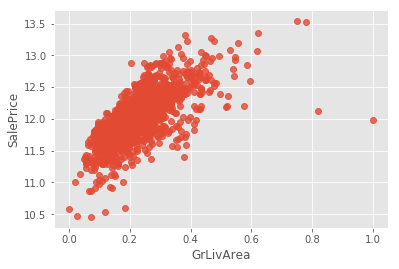

In [8]:
# 觀察重要特徵與目標的分布
# 第一名 : GrLivArea        
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
sns.regplot(x=df['GrLivArea'], y=train_Y, fit_reg=False)
plt.show()

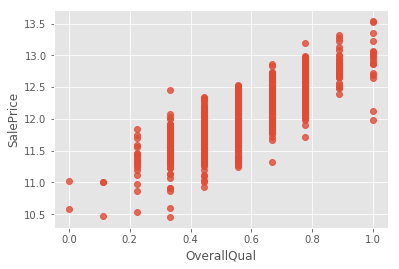

In [9]:
# 第二名 : OverallQual
sns.regplot(x=df['OverallQual'], y=train_Y, fit_reg=False)
plt.show()

In [10]:
# 製作四特徵 : 加, 乘, 互除(分母加1避免除0) 看效果 (Note: 數值原本已經最大最小化介於 [0,1] 區間, 這四種新特徵也會落在 [0,1] 區間)
df['Add_char'] = (df['GrLivArea'] + df['OverallQual']) / 2
df['Multi_char'] = df['GrLivArea'] * df['OverallQual']
df['GO_div1p'] = df['GrLivArea'] / (df['OverallQual']+1) * 2
df['OG_div1p'] = df['OverallQual'] / (df['GrLivArea']+1) * 2
train_X = MMEncoder.fit_transform(df)
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.8951796825198091

## 先用梯度提升機對鐵達尼生存預測做訓練，再用其特徵重要性回答下列問題

In [11]:
# 做完特徵工程前的所有準備 (與前範例相同)
import pandas as pd
import numpy as np
import copy
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier

data_path = 'data/'
df = pd.read_csv(data_path + 'titanic_train.csv')

train_Y = df['Survived']
df = df.drop(['PassengerId', 'Survived'] , axis=1)
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [12]:
# 因為需要把類別型與數值型特徵都加入, 故使用最簡版的特徵工程
LEncoder = LabelEncoder()
MMEncoder = MinMaxScaler()
for c in df.columns:
    df[c] = df[c].fillna(-1)
    if df[c].dtype == 'object':
        df[c] = LEncoder.fit_transform(list(df[c].values))
    df[c] = MMEncoder.fit_transform(df[c].values.reshape(-1, 1))
df.head()

D:\software\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
D:\software\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
D:\software\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
D:\software\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
D:\software\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxSc

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1.0,0.121348,1.0,0.283951,0.125,0.0,0.769118,0.014151,0.000000,1.000000
1,0.0,0.213483,0.0,0.481481,0.125,0.0,0.876471,0.139136,0.557823,0.333333
2,1.0,0.396629,0.0,0.333333,0.000,0.0,0.983824,0.015469,0.000000,1.000000
3,0.0,0.305618,0.0,0.444444,0.125,0.0,0.072059,0.103644,0.380952,1.000000
4,1.0,0.016854,1.0,0.444444,0.000,0.0,0.694118,0.015713,0.000000,1.000000


In [13]:
# 梯度提升樹擬合後, 將結果依照重要性由高到低排序 (note : D27作業中'Ticket'是第一名特徵, 'Age'是數值特徵中排名最高者)
estimator = GradientBoostingClassifier()
estimator.fit(df.values, train_Y)
feats = pd.Series(data=estimator.feature_importances_, index=df.columns)
feats = feats.sort_values(ascending=False)
feats

Ticket      0.211728
Name        0.182832
Age         0.172245
Fare        0.153156
Sex         0.134911
Cabin       0.070715
Pclass      0.031500
SibSp       0.016741
Parch       0.016663
Embarked    0.009509
dtype: float64

# 作業1
* 將特徵重要性較低的一半特徵刪除後，再做生存率預估，正確率是否有變化?
#### A : 模型預測能力並沒有因為只使用重要性較高的特徵而較好


In [14]:
# 原始特徵 + 梯度提升樹
train_X = MMEncoder.fit_transform(df)
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.8204799511452461

In [19]:
feats[:5].index

Index(['Ticket', 'Name', 'Age', 'Fare', 'Sex'], dtype='object')

In [20]:
list(feats[:5].index)

['Ticket', 'Name', 'Age', 'Fare', 'Sex']

In [21]:
# 高重要性特徵 + 梯度提升樹 
high_feature = list(feats[:5].index)
train_X = MMEncoder.fit_transform(df[high_feature])
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.8092060499605113

# 作業2
* 將特徵重要性最高的兩個特徵做特徵組合，是否能再進一步提升預測力?
#### A : 將特徵做組合後，可以提升預測能力。如Day26、27 所教的特徵組合

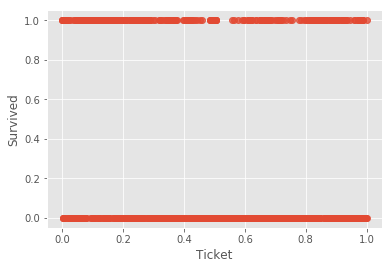

In [22]:
# 觀察重要特徵與目標的分布 : 因為是類別型態轉標籤編碼，所以只有 0 或 1
# 第一名 : Ticket              
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
sns.regplot(x=df['Ticket'], y=train_Y, fit_reg=False)
plt.show()

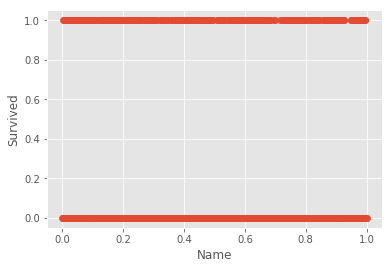

In [23]:
# 第二名 : Name        
sns.regplot(x=df['Name'], y=train_Y, fit_reg=False)
plt.show()

In [24]:
# 製作新特徵看效果
df['ADD_feature'] = df['Ticket'] + df['Name']
df['multi_feature'] = df['Ticket'] * df['Name']

train_X = MMEncoder.fit_transform(df)
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.835017644949778